Assignement 1 by:
Alfredo Ricci s1886585
Pawel Pomorski 

In [1]:
%pylab inline
from scipy.io import loadmat
from scipy import fft,ifft

Populating the interactive namespace from numpy and matplotlib


# Question 1

## Part A

In [2]:
dat = loadmat('amp_data.mat')
df = dat['amp_data']

/Users/AlfredoRicci/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3194: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/AlfredoRicci/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/AlfredoRicci/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


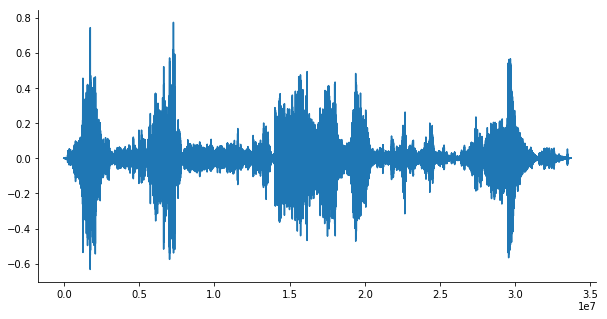

In [3]:
figure(figsize(10,5))
ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
plot(df)

vare = []
for i in range(100000):
    vare.append(np.var(df[:i]))
    


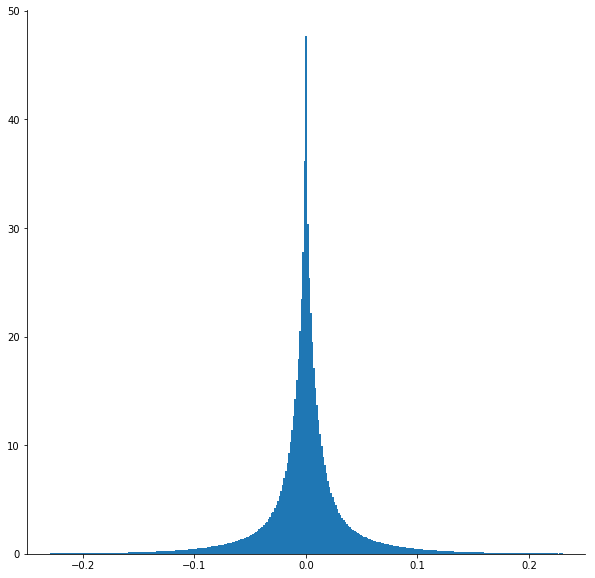

In [4]:
figure(figsize(10,10))
ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
plt.hist(df, bins = 1000,normed=1)
xlim(-0.25,0.25)

plt.show()

The first plot shows heteroskedasticity of the process with respect to time which suggests that the amplitude's volatility is conditional on previous observations. Data exhibits high excess kurtosis which might suggest it incorporates two distinct underlying distributions: strongly concentrated low-volatility intervals around (-0.1, 0.1) and a few high-volatility intervals which are visible in the long tails of the histogram plot. Some known probability density functions which comprise two distinct underlying distributions and hence could generate such a procces are Pareto distribution and skewed Laplacian distribution.

## Part B

In [5]:
#reshape data
df1 = df[:(len(df)//21)*21]
df2 = df1.reshape(len(df)//21, 21)

#shuffle data
df3 = df2[np.random.RandomState(seed=1).permutation(len(df2))]
tranlen = int(len(df3)*0.7)
vallen = tranlen + int(len(df3)*0.15)
testlen = vallen + int(len(df3)*0.15) + 1

#training set
X_shuf_train = df3[:tranlen,:20]
y_shuf_train = df3[:tranlen,20]

#validation set 
X_shuf_val = df3[tranlen:vallen,:20]
y_shuf_val = df3[tranlen:vallen,20]

#test set
X_shuf_test = df3[vallen:testlen,:20]
y_shuf_test = df3[vallen:testlen,20]

# Question 2

## Part A

/Users/AlfredoRicci/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  # This is added back by InteractiveShellApp.init_path()


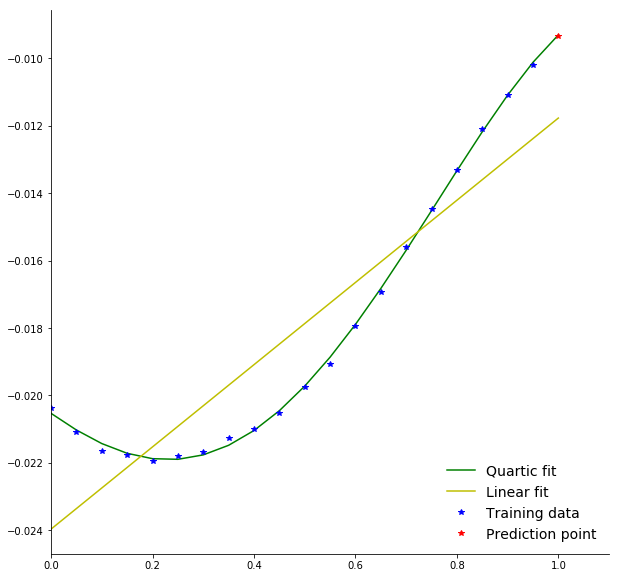

In [6]:
xs = np.arange(0,1,0.05)

phi = lambda x, func: np.concatenate([np.ones((x.shape[0],1)), func(x)], axis=1)

quartic = lambda x: np.array([x, x**2, x**3, x**4]).T
onex = lambda x: np.array([x]).T


def fit(phi_fn, x):
    ''' takes an array of basis functions phi, x values to iterate over and observed y '''
    fit = np.linalg.lstsq(phi_fn, x)
    w_fit = fit[0]
    fits = phi_fn @ w_fit
    y_pred = np.sum(w_fit)
    return np.append(fits, y_pred)
fitx = np.append(xs, 1)

figure(figsize(10,10))
ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
plot(fitx, fit(phi(xs, quartic), X_shuf_train[0]), '-g',label='Quartic fit')
plot(fitx, fit(phi(xs, onex), X_shuf_train[0]), '-y', label='Linear fit')
plot(xs, X_shuf_train[0], 'b*',label='Training data')
plot([1], y_shuf_train[0], 'r*',label='Prediction point')
xlim(0,1.1)
legend(loc=4,prop={'size': 14},frameon=False)

## Part B

If we only use the past 2 observations, quartic fit would probably result in an overfitted model, whereas for a linear fit we have at worst as many observations as dimensions (if we include the bias term). In long term, the quartic fit will be more suitable beacuse it approximates the underlying data process up to its $4^{th}$ derivative.

## Part C

We think that for a one-step-ahead prediction a quadratic or linear fit can be sufficient in modelling the curve. quadratic will include concavity but can lead to overfitting. In this sense using one or two lagged values should give the best result. 

# Question 3

## Part A

Let's start by the Least Square definition of $\pmb{w}=(\Phi^T\Phi)^{-1}(\Phi^T\pmb{x})$.<br>
Since $f$ is a real scalar, $f=\pmb{w}^T\pmb{\phi}=\pmb{\phi}^T\pmb{w}$ therefore, <br>
$f(t)=\pmb{\phi}(t)^T(\Phi^T\Phi)^{-1}(\Phi^T\pmb{x})$, <br> but we are interested in t=1. Since $\pmb{\phi}$ is built on powers of $t$, $\pmb{\phi}(t=1)$ will be a vector of ones. <br> Following, $f(t)=\pmb{v}^T\pmb{x}$ by definition, so $\pmb{v}^T=\pmb{\phi}(1)^T(\Phi^T\Phi)^{-1}\Phi^T$ and finally, $\pmb{v}=\Phi(\Phi\Phi^T)^{-1}\pmb{\phi}(1)$.

## Part B

In [7]:
#Phi function
def Phi(C,K):
    resp=np.zeros((C,K))
    for i in range (C):
        for j in range (K):
            resp[i,j]=((20-(C-i))/20)**j
    return np.mat(resp)

#V function
def make_vv(C,K):
    one=np.ones((1,K))
    the_Phi=Phi(C,K)
    return (one*((((the_Phi.T)*(the_Phi)).I)*the_Phi.T)).T

#computing all possible V to low running time. 
all_vv={}

for i in range (1,20):
    for j in range (1,20):
        name='a'+str(i)+'b'+str(j)
        all_vv[name]=make_vv(i,j)

In [8]:
#Value obtained in Excercise 2
print("Result using first method: ",round(fit(phi(xs, quartic), X_shuf_train[0])[-1],6))

Result using first method:  -0.009301


/Users/AlfredoRicci/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  # This is added back by InteractiveShellApp.init_path()


In [9]:
#Value obtained in Excercise 3
x = X_shuf_train[0].reshape(20,1)
print("Result using second method: ",round(float((make_vv(20,5).T)*x),6))

Result using second method:  -0.009301


In [10]:
#Target value
print("Target value: ", round(y_shuf_train[0],6))

Target value:  -0.009338


Using both methods the exact same result is achieved, with similar computation times. Both results are close to the target value. 

## Part C

In [11]:
#function used to compute mean squared error for all C and K bellow C_max and K_max. 
#returns a matrix with indexes C-1,K-1
def mean_squared_error(C_max,K_max):
    resp=np.zeros((C_max-1,K_max-1))
    for C in range (1,C_max):
        for K in range (1,K_max):
            V=all_vv['a'+str(C)+'b'+str(K)]
            residuals=(np.mat(X_shuf_train[:,20-C:])*V-np.mat(y_shuf_train[:]).T)
            resp[C-1,K-1]=(1/size(y_shuf_train))*residuals.T*residuals
    return resp

(array([-2.5,  0. ,  2.5,  5. ,  7.5, 10. , 12.5, 15. , 17.5, 20. ]),
 <a list of 10 Text yticklabel objects>)

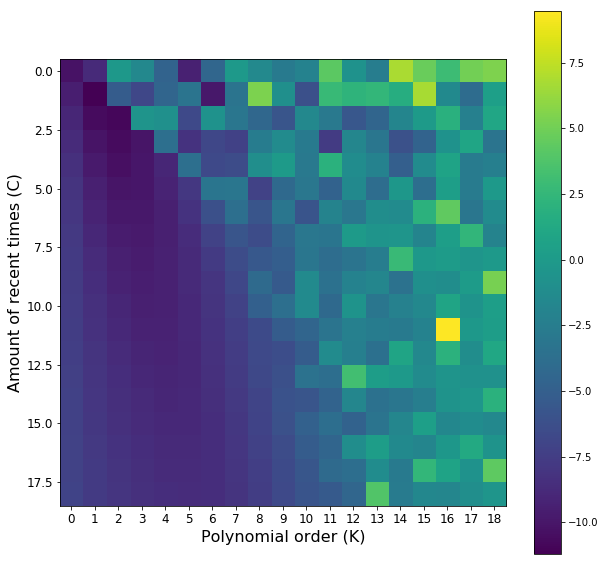

In [12]:
#Create a matrix with all errors for all C,K up to 20. 
mat_errors=mean_squared_error(20,20)

#Display the matrix using logarithmic scale for better visibility. 
imshow(np.log(mat_errors))
colorbar()

#Plot adjustments 
xlabel('Polynomial order (K)',fontsize=16)
ylabel('Amount of recent times (C)',fontsize=16)
xticks(linspace(0,18,19),fontsize=12)
yticks(fontsize=12)

### i)

In [13]:
#finding "argmin" of the error matrix. 
C_opti,K_opti=unravel_index(mat_errors.argmin(), mat_errors.shape)
C_opti+=1
K_opti+=1

print("The optimal error is get when C=",C_opti,"and K=",K_opti)

The optimal error is get when C= 2 and K= 2


From the two previous block it is possible to see that the best fit is obtained when a linear fit is done, using only the two data points before the predicted point. 

Also, notice that when $K>C$ the error increases rapidly. This is a clear sign of overfitting. This line of overfitting is clear for small values of $K$ and $C$. 

### ii) 

In [14]:
#Error for the train set
V=all_vv['a2b2']

#Error for the test set 
residuals_test=(np.mat(X_shuf_test[:,20-2:])*V-np.mat(y_shuf_test[:]).T)
score_test=(1/size(residuals_test))*residuals_test.T*residuals_test

#Error for the validation set
residuals_val=(np.mat(X_shuf_val[:,20-2:])*V-np.mat(y_shuf_val[:]).T)
score_val=(1/size(residuals_val))*residuals_val.T*residuals_val

print("The mean squared error for the train set is: "+str(round(mat_errors[1,1],8)))
print("The mean squared error for the test set is: "+str(round(score_test[0,0],8)))
print("The mean squared error for the validation set is: "+str(round(score_val[0,0],8)))

The mean squared error for the train set is: 1.341e-05
The mean squared error for the test set is: 1.371e-05
The mean squared error for the validation set is: 1.391e-05


The three errors are very close to each other, since there was no "real" training. The data was used to choose the parameters $C$ and $K$ which are usually chosen from the validation set. For this excercise there is no real difference between the the validation and training more than the fact that they were splited randomly. 

# Question 4

## Part A

In [15]:
#Create a matrix of lagged values for a given t. Return in order {t-C,....t-1}
matlag = lambda x,t : x[:,x.shape[1]-t:]

#A)_____________________________________________________
#Initialise list for errors
error = list()

#Initialise list for weight fits (for use to get validation errors)
weight = list()

#Iterate for all context lengths
for C in range(1,21):
    #matrix shape N X C
    matrix = matlag(X_shuf_train, C)
    fit = np.linalg.lstsq(matrix, y_shuf_train)
    #weight fit shape (C,)
    weight.append(fit[0])
    x = matrix @ weight[C-1]
    error.append(np.mean((y_shuf_train - x)**2))
    
#Print for which context length the error is lowest
print("Context length with lowest error: ",np.argmin(error) + 1,"; Prediction error: ", np.min(error))

#Initialise error for the validation test
newerror = list()

#Iterate for all context lengths, use weights from fits on the training test
for C in range(1,21):
    x = matlag(X_shuf_val,C) @ weight[C-1]
    newerror.append(np.mean((y_shuf_val - x)**2))


#Print for which context length the error is lowest
print("Context length with lowest error: ",np.argmin(newerror) + 1,"; Prediction error: ", np.min(newerror))


/Users/AlfredoRicci/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  from ipykernel import kernelapp as app


Context length with lowest error:  20 ; Prediction error:  7.659260668393035e-06
Context length with lowest error:  18 ; Prediction error:  7.752820987042666e-06


Context length of 20 results in lowest MSE of $7.66 \times 10^{-6}$ on the training dataset. It is probably beacuse having higher feature space provides more information about the data and therefore improves prediction. The lowest error on the validation set is for the lag of 18, at $7.75 \times 10^{-6}$. It might be the case that from lag 19 the model starts to overfit. Note that weights on the high lags of the amplitude are relatively low and would probably tend to 0 if we included regularisation.

## Part B

In [16]:
#Best model from Q4 is with lag 18
x0 = matlag(X_shuf_test,18) @ weight[17]
resids = y_shuf_test - x0
print("The mean squared error for the test set in polynomial model is (Q3): "+str(round(score_test[0,0],8)))
print("The mean squared error for the test set in autoregressive model with lag 18 is (Q4): ",round(np.mean(resids**2),9))



The mean squared error for the test set in polynomial model is (Q3): 1.371e-05
The mean squared error for the test set in autoregressive model with lag 18 is (Q4):  8.111e-06


The autoregressive model has better results over the test set by one order of magnitude. However it uses 10 times more parameters. 

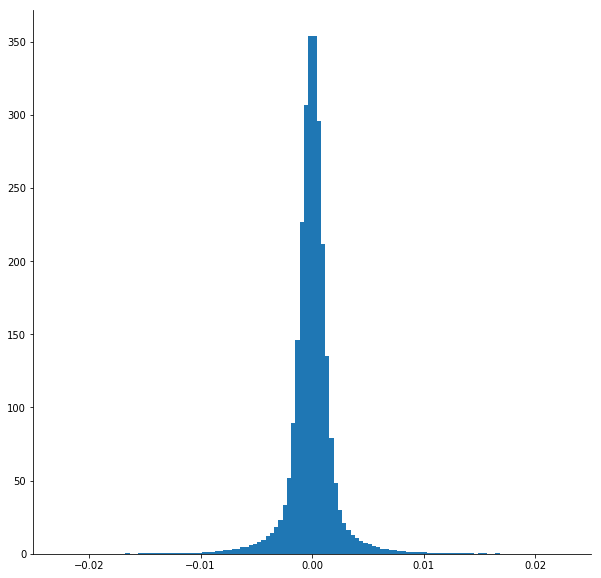

In [17]:
figure(figsize(10,10))
ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)
plt.hist(resids, bins = 1000,normed=1)
xlim(-0.025,0.025)
#ylim(0,10)
plt.show()

The distribution has almost zero mean, showing absence of systemic error in the model. It's also symetric which implies that the function is overvalues as many times as it is undervalued. It appears to have similar shape to the amplitude distribution.

# Question 5

Below is the plot of the residuals for our AR(18) model from Q4 applied to the whole and sequential dataset, against every $21^{st}$ amplitude:

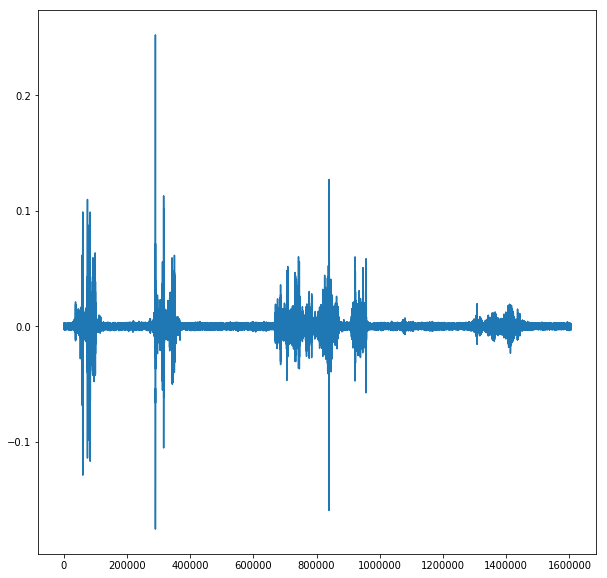

In [18]:
x0 = matlag(df2[:,:20],18) @ weight[17]
newresids = df2[:,20] - x0
plt.plot(newresids)

There are concentrations of high error which correspond to high volatility clusters visible in the amplitude plot. In sequential data, we could use a GARCH model of conditional volatility where the error is a function of its previous values in order to account for high-volatility periods.

We could introduce constraints such as generative rules for classical music to improve predictions. By introducing regularisation, we would punish overparametrisation and thus extrapolate more smoothly and avoid overfitting. We could train the model on the rolling values, not just every $21^{st}$ amplitude. I.e. we would use every $C^{th}$ value to train a model of $C$ context length.

Instead of using polynomials over 20 data points, sinusoidal basis could be used (similar to fourier transform), since music can easily be decomposed into sine and cosine functions.

Furthermore, sound usually comes with gaussian white noisse added to it, due to ambient factors and electronic noise. This will add an extra distribution to the data, so filtering the data before processing will remove this noise and it's distribution will make no effect on the predictions, and a better result can be obtained. Removing this noise should improve the quality of the actual sound. Filter needs to be picked carefully to avoid killing small frequencies that are part of the sound. A plot of a segment of the sound filtered is displayed. 

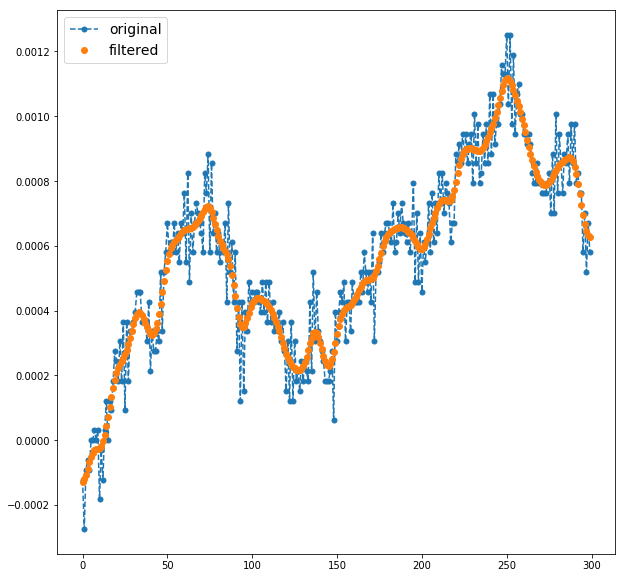

In [19]:
from scipy.ndimage import gaussian_filter
figure(figsize(10,10))
plot(df[100000:100300],"--o",ms=5,label="original")
plot(gaussian_filter(df[100000:100300],3),"o",label="filtered")
legend(prop={'size': 14})

If the block of code where the data is defined is changed to the following,

In [20]:
#reshape data
df1 = df[:(len(df)//21)*21]
df2 = df1.reshape(len(df)//21, 21)

#shuffle data
df3 = df2[np.random.RandomState(seed=1).permutation(len(df2))]
tranlen = int(len(df3)*0.7)
vallen = tranlen + int(len(df3)*0.15)
testlen = vallen + int(len(df3)*0.15) + 1

#training set
X_shuf_train = gaussian_filter(df3[:tranlen,:20],3)
y_shuf_train = gaussian_filter(df3[:tranlen,20],3)

#validation set 
X_shuf_val = gaussian_filter(df3[tranlen:vallen,:20],3)
y_shuf_val = gaussian_filter(df3[tranlen:vallen,20],3)

#test set
X_shuf_test = gaussian_filter(df3[vallen:testlen,:20],3)
y_shuf_test = gaussian_filter(df3[vallen:testlen,20],3)

In the case of our data, the error for the test and validation sets goes down by a factor of 10. One needs to be careful when applying this technique, since the actual data is being modified and generalization might not be possible. This techinqiue should only be applied when knowing about the existence of noise in data. 

Finally, there is a way to multiply by 20 the number of observations. The way the data is splited right now takes position $x_0$ - $x_{19}$ to predict $x_{20}$, and then $x_{21}$ - $x_{40}$ to predict $x_{41}$. However data could also be splitted so we use $x_0$ - $x_{19}$ to predict $x_{20}$ and then use $x_1$ - $x_{20}$ to predict $x_{21}$, increasing by an order of magnitud the amount of observations, and thus probably achieving better results. 